# CS541: Applied Machine Learning, Spring 2025, Lab 9


Lab 9 is an exercise that explores Reinforcement Learning. In reinforcement learning, an agent learns to make decisions by interacting with an environment, it is used in robotics and other decision-making settings. Reinforcement learning works by having an agent interact with an environment and through trial-and-error is rewarded or punished based on certain actions. Based on the modeling on the environment the action can learn from it's environment but sometimes this may need to be adjusted to help the agent better learn.

**Lab Grading**

Labs are hands-on exercises designed to provide guided experience in key concepts through this class.  You are graded based on in-lab participation (not correctness), and **are required to submit** your lab work after class, before Friday of that week.  *Make sure you fill out the attendence form before leaving class*.

For students who miss a lab, you can submit a make-up lab on gradescope by the Friday directly following the lab for partial credit.  Please see the syllabus for the lab grading policy.

Fun references for RL and Q Learning: http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture14.pdf




In [1]:
!apt update
!apt-get install -y xvfb ffmpeg x11-utils
!pip install gym pyvirtualdisplay PyOpenGL PyOpenGL-accelerate
!pip install xvfbwrapper

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,773 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,241 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/restrict

In [1]:
!pip install numpy==1.23.5

In [2]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from IPython.display import clear_output
import imageio
import base64
import math
from IPython.display import Image

## Let's teach a machine to balance a cartpole

https://www.gymlibrary.dev/environments/classic_control/cart_pole/

<img src="https://www.gymlibrary.dev/_images/cart_pole.gif">



In [4]:
env = gym.make('CartPole-v1')

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### We need to discretize the state space.

Which means:

Make a list of all possible states with possible values. Since angles can be continous and range from -infinity to +infinity, we need to define some coarse values to make it into a finite list.

The funtion `discretize_state(observation, state_space)` does that for you.

It takes in the environment (which is the cartpole simulator) and the current state, defined by 4 parameters:
1. Cart Position: ranges from -4.8 to 4.8
2. Cart Velocity: ranges from -Inf to Inf
3. Pole Angle: ranges from  -0.418 rad (-24°) to 0.418 rad (24°)
4. Pole Angular Velocity: -Inf to Inf

Since we cannot have infinite values, we cap it to some min and max value.

`discretize_state(observation, state_space)` will take in the 4 state space values, and turn it into an index in a flattened list indicating that state.




In [6]:

# Discretize the state space
# Example discretization: 30 bins for each of the 4 state values
state_space = [30, 30, 30, 30]
#Get the product of the state_space values
state_space_size = np.prod(state_space)

print(f"Possible number of states : {state_space_size}")


# Define a simple method to discretize continuous state space
def discretize_state(observation, state_space):

    # For the upper_bounds let position 0 be the first highest value in the observation_space
    # For the upper_bounds let position 1 be the third highest value in the observation_space
    upper_bounds = [4.8, 0.5, math.radians(24), math.radians(50)]
    # For the lower bound let position 0 be the first lowest value in the observation_space
    # For the lower bound let position 1 be the third lowest value in the observation_space
    lower_bounds = [-4.8, -0.5, math.radians(-24), -math.radians(50)]

    # Let the ratios be the (observation at position i plus the absolute lower_bounds value at position i)
    # We devide that by the (upper bounds at position i minus the lower bounds at position i)
    ratios = [(observation[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(observation))]
    new_observation = [int(round((state_space[i] - 1) * ratios[i])) for i in range(len(observation))]
    #print(new_observation)

    # For the new observation we will get the minimum of the ( (state space at position i minus 1), max(0, new_observation[i]) )
    new_observation = [min(state_space[i] - 1, max(0, new_observation[i])) for i in range(len(observation))]
    #print(new_observation)
    return tuple(new_observation)

Possible number of states : 810000


In [11]:
env.reset() # gives the initial start state.

array([ 0.00789265,  0.02083663, -0.02267869,  0.04495358], dtype=float32)

## Let's train the Q-learning agent.

Play with the **`exploration_rate`, `exploration_decay_rate`**, and tweak the **`reward`** and see how the behavior changes.

Sometimes, tricks as simple as training for longer (change **`episodes`**) can make a huge difference.

In [14]:
class QLearningAgent:
    def __init__(self, action_space, state_space, learning_rate=0.1, discount_factor=0.95, exploration_rate=1.0, exploration_decay_rate=0.9999995):
        #Assign the corresponding args to the class instance variables
        self.action_space = action_space
        self.state_space = state_space
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay_rate = exploration_decay_rate
        # We define the q-table to a numpy array with zeros with number of rows being the state_space arg and the columns being the action_space
        self.q_table = np.zeros((state_space, action_space))

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.exploration_rate:
            #Random y choose a element from the action_space using numpy
            return np.random.randint(self.action_space)
        else:
            # Using numpy to get the argmax of the q-table at state position
            return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state, done):
        # Get the element from the q-table at the row at the state position and the column at the action position
        predict = self.q_table[state, action]
        # The target is -0.5 if done else it is the reward plus the discount_factor multiplied by the np max value of the q-table at the next_state
        target = -0.5 if done else reward + self.discount_factor * np.max(self.q_table[next_state])
        # for the q-table value at the row at the state position and the column at the action position, we add that to the learning-rate multiplied by the (target minus the predict value)
        self.q_table[state, action] += self.learning_rate * (target - predict)
        if not done:
            self.exploration_rate *= self.exploration_decay_rate

In [15]:
agent = QLearningAgent(env.action_space.n, state_space_size, exploration_rate=1.0, exploration_decay_rate=0.999995)

def train_agent(episodes=40000):
    for episode in range(episodes):
        current_state = discretize_state(env.reset(), state_space)
        current_state = np.prod(current_state)
        #print("Current state", current_state)
        done = False
        count=0
        while not done:
            count+=1
            action = agent.choose_action(current_state)

            next_state, reward, done, _ = env.step(action)

            ## Example of other things to tweak the reward
            # angle = next_state[2]

            next_state_discrete = discretize_state(next_state, state_space)
            next_state_discrete_ind = np.prod(next_state_discrete)

            agent.learn(current_state, action, reward, next_state_discrete_ind, done) # tweak the reward input here
            current_state = next_state_discrete_ind

        if episode % 100 == 0:
            print(f"Episode: {episode}, Exploration rate: {agent.exploration_rate}")

train_agent()

Episode: 0, Exploration rate: 0.9998900057748068
Episode: 100, Exploration rate: 0.9888426817103378
Episode: 200, Exploration rate: 0.9774676747534617
Episode: 300, Exploration rate: 0.9671805558543086
Episode: 400, Exploration rate: 0.9567576962840626
Episode: 500, Exploration rate: 0.9464613559221781
Episode: 600, Exploration rate: 0.9364022277819603
Episode: 700, Exploration rate: 0.9272610100568994
Episode: 800, Exploration rate: 0.9182962636964102
Episode: 900, Exploration rate: 0.9090181313931909
Episode: 1000, Exploration rate: 0.8998967326968523
Episode: 1100, Exploration rate: 0.8909024967096051
Episode: 1200, Exploration rate: 0.8821128232938582
Episode: 1300, Exploration rate: 0.8731653479458378
Episode: 1400, Exploration rate: 0.8641919548385288
Episode: 1500, Exploration rate: 0.8561622398710295
Episode: 1600, Exploration rate: 0.8470374122255468
Episode: 1700, Exploration rate: 0.8378003586028352
Episode: 1800, Exploration rate: 0.8284030475404358
Episode: 1900, Explorati

## Now let's test the learned algorithm
## We want to try and get the pole to balance for 120 frames
## Maybe try and update the hyperparameters for the algorith to achieve this

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. S

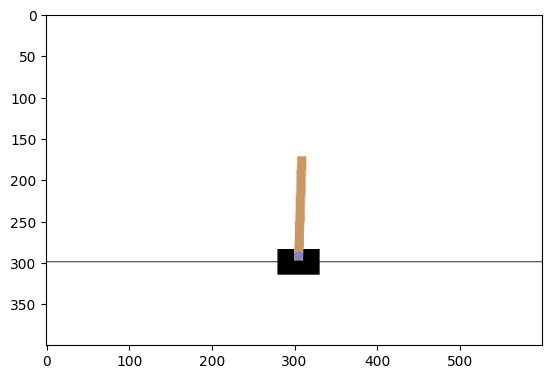

In [16]:
frames = []
env.close()  # Close the previous env
env = gym.make('CartPole-v1')  # Re-make the environment

state = discretize_state(env.reset(), state_space)
state = np.prod(state)
img = plt.imshow(env.render(mode='rgb_array')) # only call this once, only for the first frame
done = False
while not done:
    frame = env.render(mode='rgb_array')
    frames.append(frame)
    action = agent.choose_action(state)
    next_state, reward, done, info = env.step(action)
    state = discretize_state(next_state, state_space)
    state = np.prod(state)

env.close()

# Save frames as video
imageio.mimsave('cartpole-v1.gif', frames, 'GIF', fps=30)
